In [329]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [330]:
import shutil, os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split

import cv2

In [331]:
labels = pd.read_csv("C:/Users/91709/dog-breed-identification/labels1.csv")
sample = pd.read_csv('C:/Users/91709/dog-breed-identification/sample_submission.csv')
labels.head()

,Unnamed: 0,Unnamed: 0.1,id,breed
0,0,4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
1,1,9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
2,2,20,008b1271ed1addaccf93783b39deab45.jpg,doberman
3,3,25,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever
4,4,37,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever


In [332]:
# def rchop(s):
#       s=s[:-4]
#       return s
   
# labels['id']=labels['id'].apply(rchop)
labels['id']

0      0021f9ceb3235effd7fcde7f7538ed62.jpg
1      0042188c895a2f14ef64a918ed9c7b64.jpg
2      008b1271ed1addaccf93783b39deab45.jpg
3      00a366d4b4a9bbb6c8a63126697b7656.jpg
4      0100f55e4f0fe28f2c0465d3fc4b9897.jpg
                       ...                 
836    fe50bac6c389d137ea01c9cfc7346ca8.jpg
837    fe624532170510bd80627c0500bafc97.jpg
838    feb16cf86c9dac6d476e3c372ba5c279.jpg
839    febcab8eb2da444bf83336cffec7eb92.jpg
840    ff6f47aa8e181b6efa4d0be7b09b5628.jpg
Name: id, Length: 841, dtype: object

In [333]:
 (unique, counts) = np.unique(labels['breed'], return_counts=True)
 print(unique,counts)
labels['breed'].value_counts()

['beagle' 'chihuahua' 'doberman' 'french_bulldog' 'golden_retriever'
 'malamute' 'pug' 'saint_bernard' 'scottish_deerhound' 'tibetan_mastiff'] [105  71  74  70  67  81  94  84 126  69]


scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

In [334]:
train_paths = 'C:/Users/91709/dog-breed-identification/sample_train/' + labels['id']

In [335]:
dog_breeds = pd.get_dummies(labels.breed).values

In [336]:
column_names = pd.get_dummies(labels.breed).columns.to_list()

In [280]:
train_datagen = Imgen(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'C:/Users/91709/dog-breed-identification/',
        target_size=(312, 312),
        batch_size=32)


Found 871 images belonging to 2 classes.


In [273]:
train_generator

In [337]:
train_path, valid_path, train_labels, valid_labels = train_test_split(train_paths, dog_breeds, test_size=0.4, random_state=101)

In [338]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_path, valid_labels))

In [339]:
def decode_train_data(image_path, label):
    
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img,[312,312])
    
    return img, label

In [340]:
train_ds = train_ds.map(decode_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(decode_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [341]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    
    return img, label

def configure_for_performance(ds, batch_size = 16):
    
    ds = ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat(100)
    ds = ds.shuffle(buffer_size=25)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [342]:
train_ds_batch = configure_for_performance(train_ds)
valid_ds_batch = valid_ds.batch(32)

In [344]:
train_ds_batch.batch

<bound method DatasetV2.batch of <PrefetchDataset shapes: ((None, 312, 312, 3), (None, 10)), types: (tf.float32, tf.uint8)>>

In [237]:
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

In [17]:
# plot_images(train_ds_batch)

In [345]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet")
for layers in base_model.layers:
    layers.trainable=True

In [346]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(312, 312, 3))
    preprocess = preprocess_input(inputs)
    outputs_resnet = base_model(preprocess)
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(outputs_resnet)
    dense_1= tf.keras.layers.Dense(512, kernel_regularizer = 'l2')(global_avg_pooling)
    bn_1 = tf.keras.layers.BatchNormalization()(dense_1)
    activation = tf.keras.layers.Activation('relu')(bn_1)
    dropout = tf.keras.layers.Dropout(0.4)(activation)
    dense_2 = tf.keras.layers.Dense(10, activation='softmax')(dropout)
    
    
    model = tf.keras.Model(inputs, dense_2)
    
    return model

In [238]:
def res_identity(x,filters):

      x_skip =x
      f1,f2 = filters

        #first block 
      x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      #second block # bottleneck (but size kept same with padding)
      x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      # third block activation used after adding the input
      x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      # x = Activation(activations.relu)(x)

      # add the input 
      x = Add()([x, x_skip])
      x = Activation(activations.relu)(x)

      return x

In [239]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [240]:
def resnet50():

  input_im = Input(shape=(312, 312, 3)) # dog breed images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 128))
  x = res_identity(x, filters=(64, 128))
  x = res_identity(x, filters=(64, 128))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 256))
  x = res_identity(x, filters=(128, 256))
  x = res_identity(x, filters=(128, 256))
  x = res_identity(x, filters=(128, 256))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 1024))
  x = res_identity(x, filters=(512, 1024))
  x = res_identity(x, filters=(512, 1024))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)
  x = Flatten()(x)
  x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x) #multi-class
  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [349]:
# base_model = resnet50()
# base_model.summary()
base_model = build_model()

base_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 312, 312, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 312, 312, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 312, 312, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_116 (Bat (None, 512)               2048

In [350]:
def lrdecay(epoch):
    lr = 1e-4
    if epoch > 25:
        lr *= 0.01
    elif epoch > 10:
        lr *= 0.1
        
    #print('Learning rate: ', lr)
    return lr

In [351]:
def earlystop(mode):
    if mode=='acc':
        estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
        mc = tf.keras.callbacks.ModelCheckpoint('C:/Users/91709/dog-breed-identification/best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
    elif mode=='loss':
        estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
        mc = tf.keras.callbacks.ModelCheckpoint('C:/Users/91709/dog-breed-identification/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    return (estop,mc)

In [352]:
base_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr = 3e-4), 
                       metrics=['acc'])
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay)

In [354]:
steps_per_epoch = len(train_paths)/16

resnet_train = base_model.fit(train_ds_batch, 
                                  epochs=50,   
                                  validation_data= valid_ds_batch, 
                                  steps_per_epoch = steps_per_epoch,
                                  callbacks=[lrdecay,earlystop('loss')])

Epoch 1/50
53/52 [==============================] - 913s 17s/step - loss: 10.0962 - acc: 0.3420 - val_loss: 10.5556 - val_acc: 0.1157 - lr: 1.0000e-04
Epoch 2/50
53/52 [==============================] - 887s 17s/step - loss: 8.8781 - acc: 0.6875 - val_loss: 10.7153 - val_acc: 0.1128 - lr: 1.0000e-04
Epoch 3/50
53/52 [==============================] - 829s 16s/step - loss: 8.1503 - acc: 0.8526 - val_loss: 10.7663 - val_acc: 0.1157 - lr: 1.0000e-04
Epoch 4/50
53/52 [==============================] - 830s 16s/step - loss: 7.6947 - acc: 0.9198 - val_loss: 11.8785 - val_acc: 0.1039 - lr: 1.0000e-04
Epoch 5/50
53/52 [==============================] - 832s 16s/step - loss: 7.3508 - acc: 0.9505 - val_loss: 11.3297 - val_acc: 0.0920 - lr: 1.0000e-04
Epoch 6/50
53/52 [==============================] - 811s 15s/step - loss: 7.0176 - acc: 0.9599 - val_loss: 11.0788 - val_acc: 0.1009 - lr: 1.0000e-04
Epoch 7/50
53/52 [==============================] - 826s 16s/step - loss: 6.6705 - acc: 0.9835 - va

KeyboardInterrupt: 

In [355]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
base_model.save("C:/Users/91709/dog-breed-identification/my_model.h5")

# It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model("my_model")

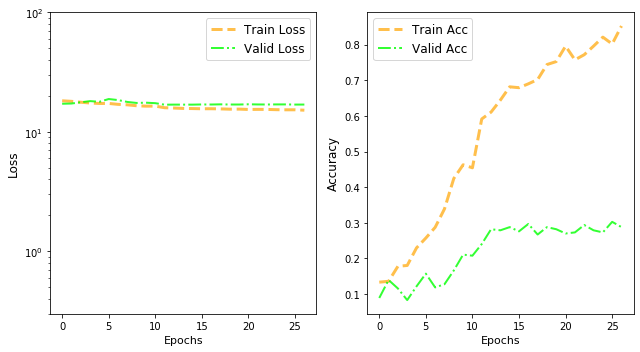

In [356]:
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [357]:
test_labels = pd.read_csv("C:/Users/91709/dog-breed-identification/test_labels1.csv")
test_labels.head()

,id,breed,label_no
0,b1.jpg,beagle,0
1,b2.jpg,beagle,0
2,b3.jpg,beagle,0
3,c1.jpg,chihuahua,1
4,c2.jpg,chihuahua,1


In [358]:
test_paths = 'C:/Users/91709/dog-breed-identification/sample_test/' + test_labels['id']
dog_breeds = pd.get_dummies(test_labels.breed).values

In [359]:
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, dog_breeds))

In [360]:
def decode_test_data(image_path,label):
    
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img,[312,312])
    
    return img,label


In [361]:
test_ds = test_ds.map(decode_test_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds_batch = test_ds.batch(15)
test_ds_batch

<BatchDataset shapes: ((None, 312, 312, 3), (None, 10)), types: (tf.float32, tf.uint8)>

In [362]:
predictions = base_model.evaluate(test_ds_batch)

2/2 [==============================] - 2s 892ms/step - loss: 5.2340 - acc: 0.8667


In [363]:
predictions = base_model.predict(test_ds_batch,use_multiprocessing=True)

In [364]:
len(predictions)

30

In [365]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
class_names = ['beagle' 'chihuahua' 'doberman' 'french_bulldog' 'golden_retriever'
 'malamute' 'pug' 'saint_bernard' 'scottish_deerhound' 'tibetan_mastiff']
class_types = [0,1,2,3,4,5,6,7,8,9]
def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_labels.label_no, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_labels.label_no,
                                np.argmax(np.round(predictions), axis=1))
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = class_types, 
                yticklabels = class_types, fmt="d")

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         3
           3       0.40      0.67      0.50         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           0.87        30
   macro avg       0.82      0.87      0.84        30
weighted avg       0.81      0.87      0.84        30



C:\Users\91709\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


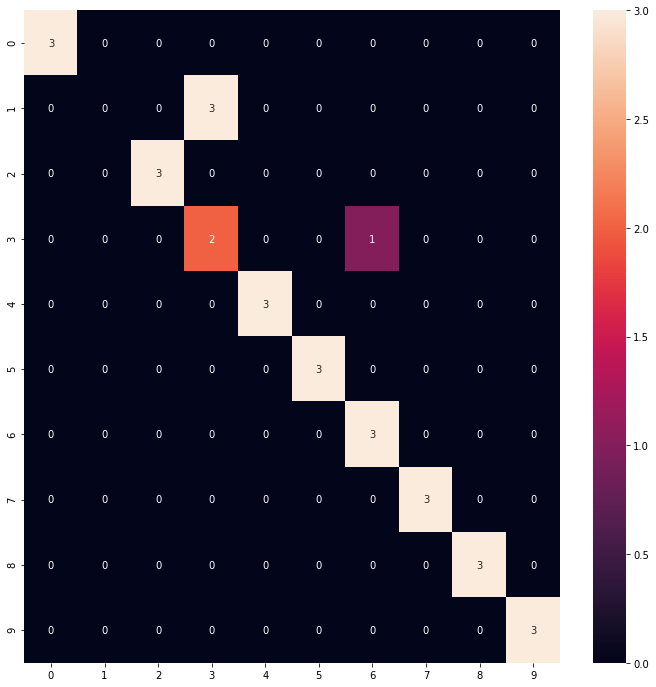

In [366]:
conf_matrix(predictions)

In [367]:
class_names = ['beagle' 'chihuahua' 'doberman' 'french_bulldog' 'golden_retriever'
 'malamute' 'pug' 'saint_bernard' 'scottish_deerhound' 'tibetan_mastiff']
class_types = [1,2,3,4,5,6,7,8,9,10]

In [368]:
np.argmax(np.round(predictions), axis=1)

array([0, 0, 0, 3, 3, 3, 2, 2, 2, 6, 3, 3, 4, 4, 4, 8, 8, 8, 5, 5, 5, 6,
       6, 6, 7, 7, 7, 9, 9, 9], dtype=int64)